# IMPORT LIBS

In [129]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
# jupyter labextension install @jupyterlab/plotly-extension
import plotly.express as px
import json
import requests
from IPython.display import Image

# READ DATA

In [130]:
raw_path = './raw/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
olist_product_category_translation = pd.read_csv(raw_path + 'product_category_name_translation.csv')

In [131]:
#merge data to master database
olist = (olist_orders
         .merge(olist_customer, on='customer_id')
         .merge(olist_order_items, on='order_id')
         .merge(olist_order_payments, on='order_id')
         .merge(olist_order_reviews, on='order_id')
         .merge(olist_products, on='product_id')
         .merge(olist_sellers, on='seller_id')
         .merge(olist_product_category_translation, on='product_category_name'))

In [132]:
#show info data
olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   customer_unique_id             115609 non-null  object 
 9   customer_zip_code_prefix       115609 non-null  int64  
 10  customer_city                  115609 non-null  object 
 11  customer_state                 115609 non-null  object 
 12  order_item_id                 

In [133]:
#check missing value
olist.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
review_id                             0
review_score                          0
review_comment_title             101808


In [134]:
#check number of customers
olist['customer_id'].nunique()

96516

In [135]:
#check number of sellers
olist['seller_id'].nunique()

3028

In [136]:
#number of product categories
olist['product_category_name'].nunique()

71

In [137]:
#number of products 
olist['product_id'].nunique()

32171

# DATA CLEANING

In [138]:
#transfer type datetime columns
datetime_columns = ['review_creation_date','review_answer_timestamp','order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in datetime_columns:
    olist[datetime_columns] = olist[datetime_columns].apply(pd.to_datetime)

In [139]:
olist['review_response_time'] = (olist['review_answer_timestamp'] - olist['review_creation_date']).dt.days
olist['time_to_delivery'] = (olist['order_delivered_customer_date'] - olist['order_purchase_timestamp']).dt.days
olist['delivery_against_estimated'] = (olist['order_delivered_customer_date'] - olist['order_estimated_delivery_date']).dt.days
olist['product_volume_cm'] = olist['product_length_cm'] * olist['product_height_cm'] * olist['product_width_cm']

# Datetime parts
olist['order_purchase_year'] = olist.order_purchase_timestamp.dt.year
olist['order_purchase_year_month'] = olist.order_purchase_timestamp.dt.strftime('%Y %m')
olist['order_purchase_hour'] = olist.order_purchase_timestamp.dt.hour
olist['order_purchase_month'] = olist.order_purchase_timestamp.dt.month.map({
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May', 
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
})
olist['order_purchase_dayofweek'] = olist.order_purchase_timestamp.dt.dayofweek.map({
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
})

In [140]:
#first transaction and end transaction in database
print(f'First observation was in: \
{olist_orders["order_purchase_timestamp"].min()}')
print(f'Last observation was in: \
{olist_orders["order_purchase_timestamp"].max()}')

First observation was in: 2016-09-04 21:15:19
Last observation was in: 2018-10-17 17:30:18


In [141]:
#dropna at olist_orders
olist.drop_duplicates(subset='order_id', inplace=True)

In [142]:
#dropna at olist_order_reviews
olist_order_reviews.drop_duplicates(subset='review_id', inplace=True)

In [143]:
olist['customer_city'] = olist['customer_city'].str.title()
olist['seller_city'] = olist['seller_city'].str.title()
olist['product_category_name_english'] = olist['product_category_name_english'].str.title().str.replace('_', ' ')
olist['payment_type'] = olist['payment_type'].str.replace('_', ' ').str.title()

In [144]:
#transfer data to date_time
olist['year'] = olist['order_purchase_timestamp'].dt.year
olist['month'] = olist['order_purchase_timestamp'].dt.month
olist['date'] = olist['order_purchase_timestamp'].dt.day.astype("Int64")

# EDA

## 1: What is the total revenue generated by Olist, and how has it changed over time?

In [145]:
#find total revenue = price + freight
olist['total_revenue'] = olist['price'] + olist['freight_value']

In [146]:
olist_sales_by_year_month = olist.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False).agg({
    'order_id': 'count',
    'total_revenue': 'sum'
})
olist_sales_by_year_month

,order_purchase_year,order_purchase_year_month,order_id,total_revenue
0,2016,2016 09,2,146.72
1,2016,2016 10,301,50772.81
2,2016,2016 12,1,19.62
3,2017,2017 01,768,120295.25
4,2017,2017 02,1670,252869.05
5,2017,2017 03,2570,385919.31
6,2017,2017 04,2310,366680.26
7,2017,2017 05,3542,518721.77
8,2017,2017 06,3137,459223.35
9,2017,2017 07,3884,521534.09


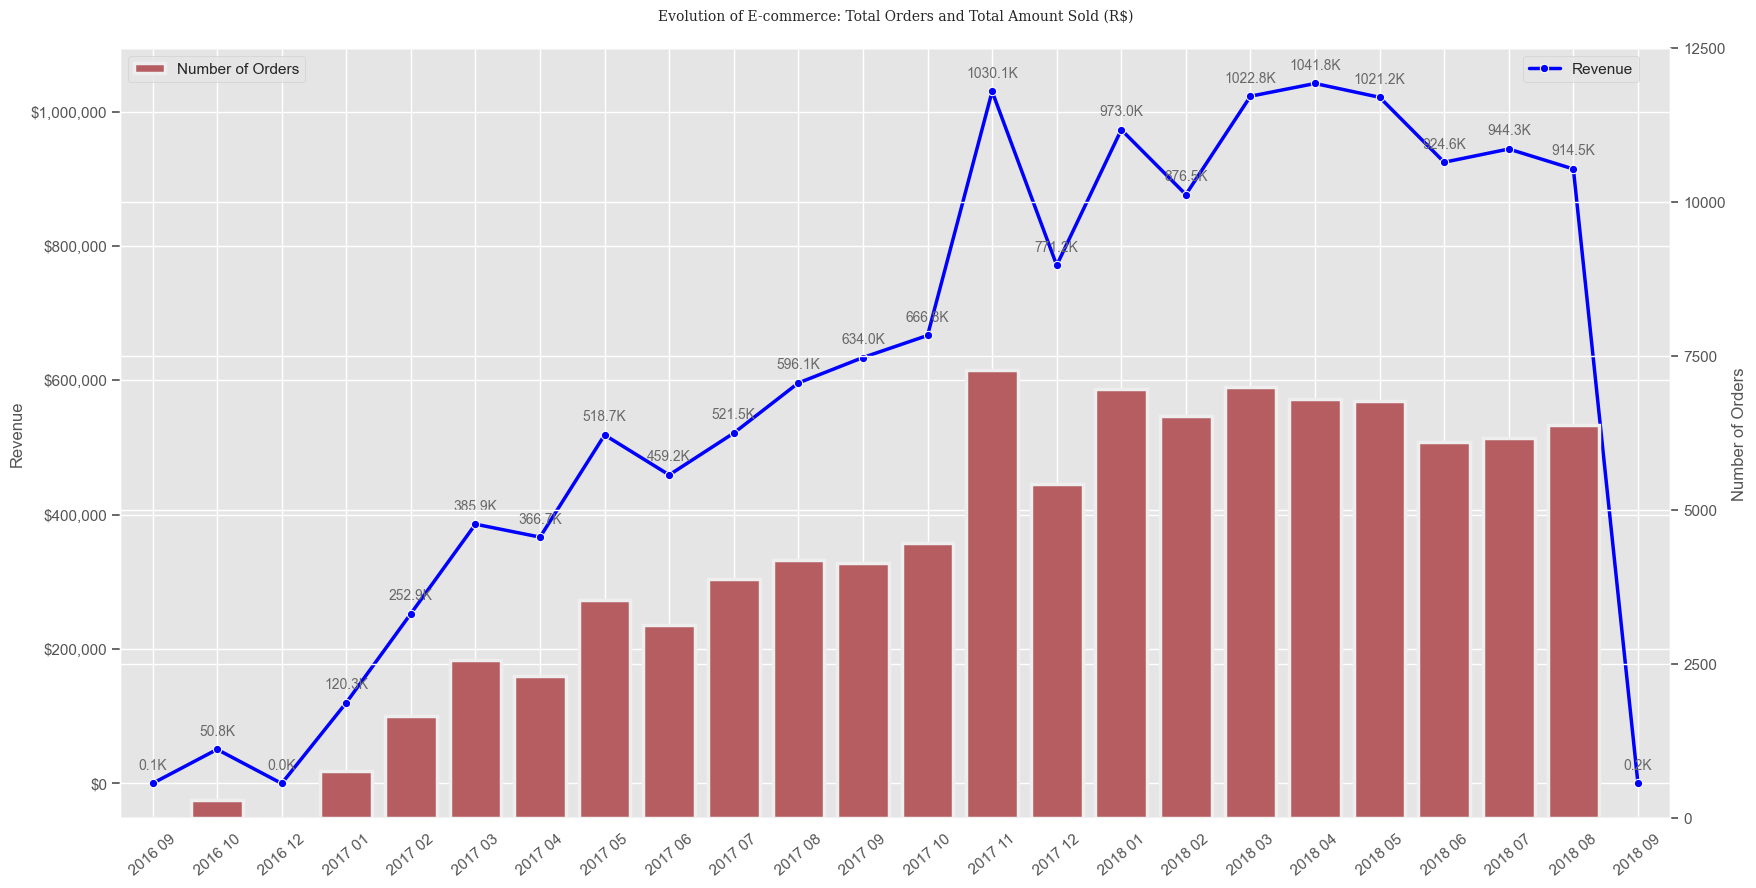

In [147]:
fig = plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='order_purchase_year_month', y='total_revenue',color ='blue' ,data=olist_sales_by_year_month, linewidth=2.5, marker='o', label='Revenue')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.9, 1))
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))


ax1_twx = ax.twinx()
sns.barplot(data=olist_sales_by_year_month, x='order_purchase_year_month', y='order_id', color='r', linewidth=2.5, ax=ax1_twx, label='Number of Orders')
ax1_twx.legend(loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

ax1_twx.set_yticks(np.arange(0, 15000, 2500))
ax1_twx.set_ylabel('Number of Orders')

for x, y in olist_sales_by_year_month.total_revenue.items():
    ax.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')
 

ax.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, font='serif', pad=20)
ax.set_xlabel('')
plt.show()

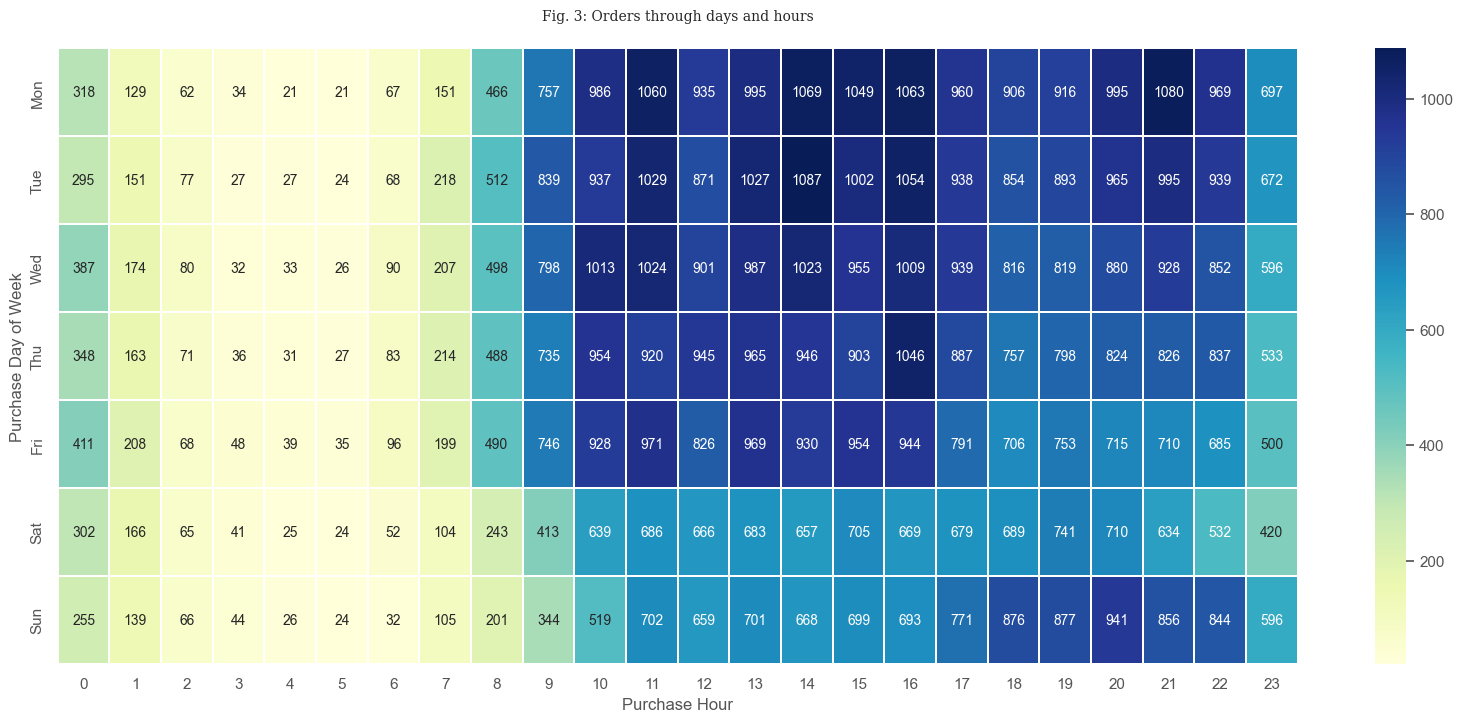

In [148]:
#
order_day_hour = olist.groupby(['order_purchase_dayofweek', 'order_purchase_hour'])['order_id'].nunique().unstack() #create new data order day, hour
plt.figure(figsize=(20,8))
ax = sns.heatmap(order_day_hour.reindex(index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']), cmap="YlGnBu", annot=True, fmt="d", linewidths=0.2) #show heatmap
ax.set_xlabel('Purchase Hour')
ax.set_ylabel('Purchase Day of Week')
ax.set_title('Fig. 3: Orders through days and hours', size=14, font='serif', pad=20)
plt.show()

* Number of orders decrease gradually from weekdays to weekends. ​
* Weekdays, especially on Monday & Tuesday are the preferred days for Brazilian's customers and they tend to buy more at the afternoons. ​
* The hottest time slots are Weekdays (10-22h) and Weekends (18-22h)

## 2:Total Orders on E-Commerce by status

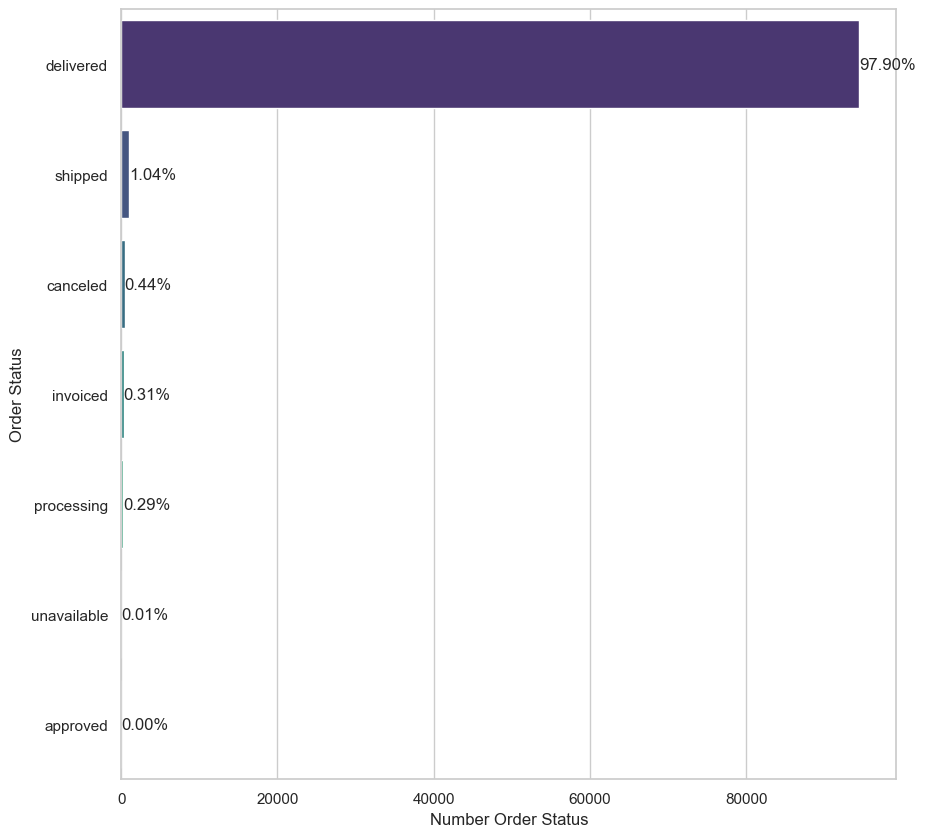

In [201]:
# Assuming 'olist' is your DataFrame

order_status_counts = olist['order_status'].value_counts()

# Calculate percentages
order_status_percentages = order_status_counts / order_status_counts.sum() * 100

# Create a horizontal bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x=order_status_counts.values, y=order_status_counts.index, palette='viridis')

# Add percentages beside the bars
for i, percentage in enumerate(order_status_percentages):
    plt.text(order_status_counts[i] + 0.5, i, f'{percentage:.2f}%', va='center')

# Set plot labels and title
plt.xlabel('Number Order Status')
plt.ylabel('Order Status')
plt.title('')

# Show the plot
plt.show()


## 3: Trend on brazilian e-commerce

In [150]:
olist_sales_by_year_month = olist.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False).agg({
    'order_id': 'count',
    'price': 'sum'
})

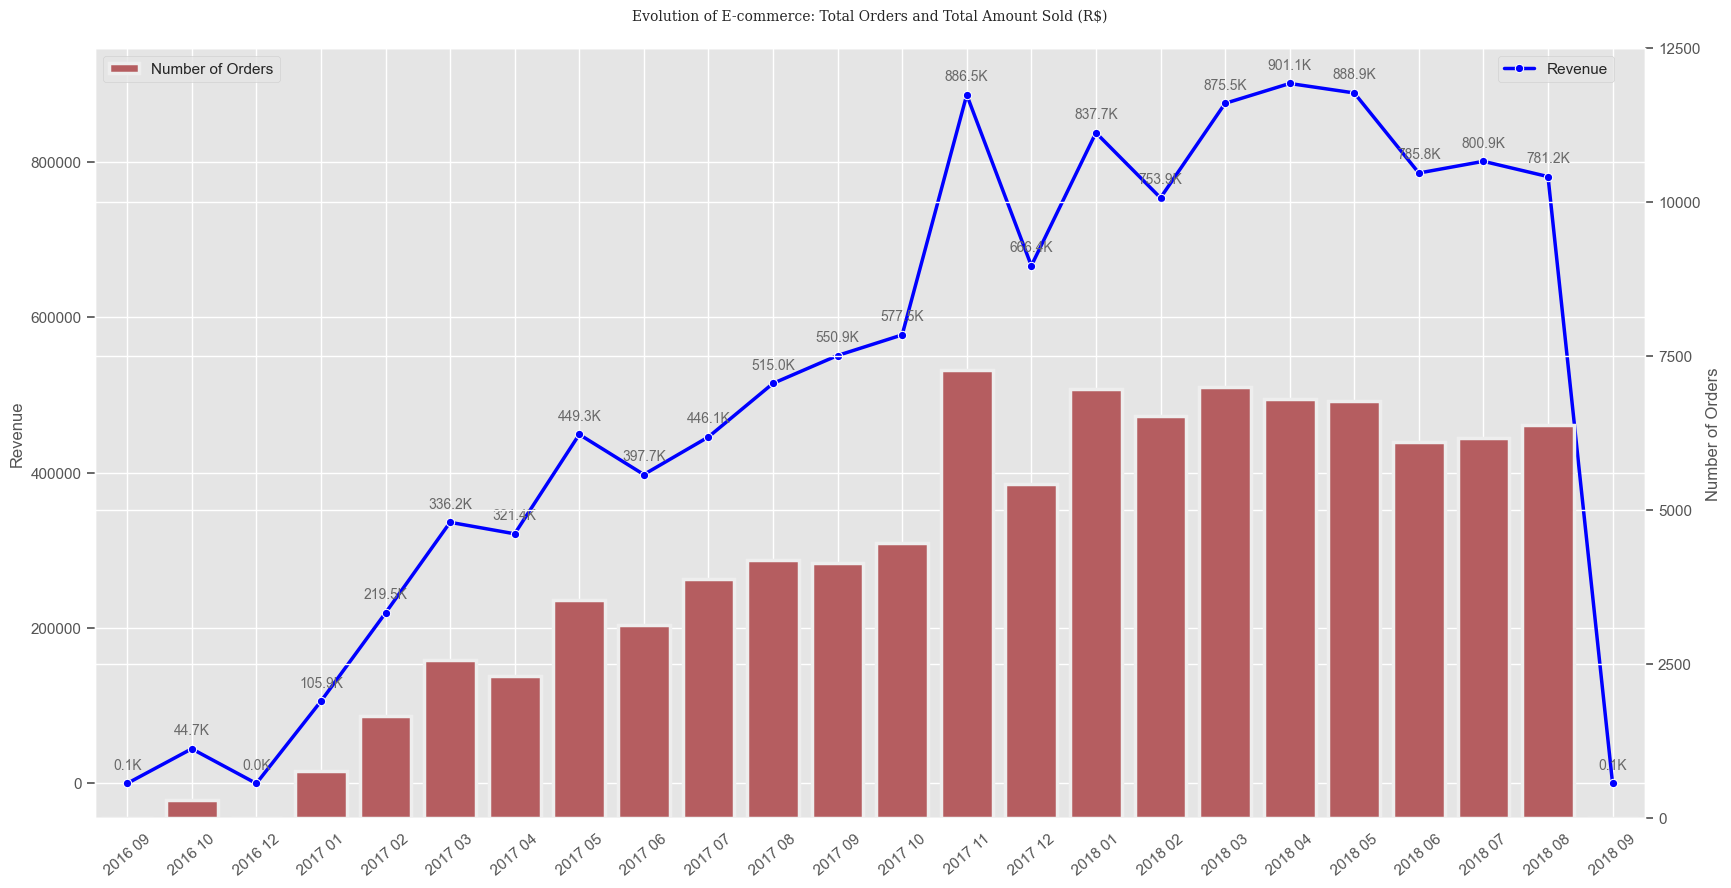

In [151]:
fig = plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='order_purchase_year_month', y='price',color ='blue' ,data=olist_sales_by_year_month, linewidth=2.5, marker='o', label='Revenue')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.9, 1))
ax.set_ylabel('Revenue')


ax1_twx = ax.twinx()
sns.barplot(data=olist_sales_by_year_month, x='order_purchase_year_month', y='order_id', color='r', linewidth=2.5, ax=ax1_twx, label='Number of Orders')
ax1_twx.legend(loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

ax1_twx.set_yticks(np.arange(0, 15000, 2500))
ax1_twx.set_ylabel('Number of Orders')

for x, y in olist_sales_by_year_month.price.items():
    ax.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')
 

ax.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, font='serif', pad=20)
ax.set_xlabel('')
plt.show()

## 4: What are the most popular product categories on Olist?

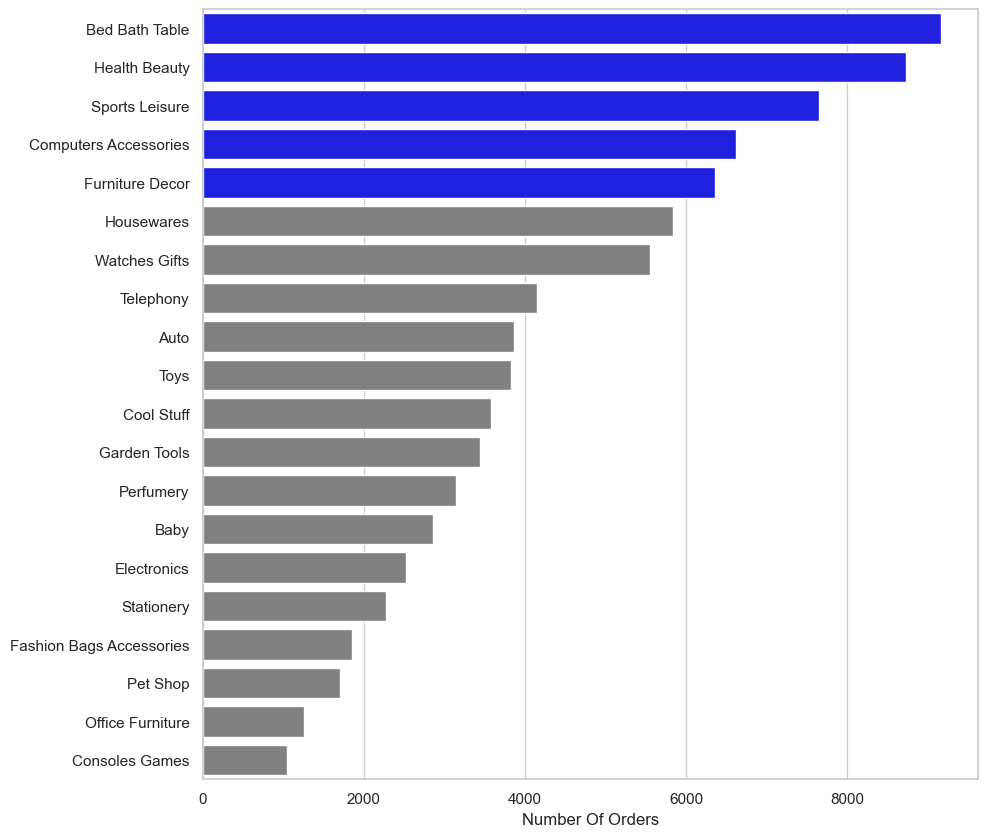

In [202]:
plt.figure(figsize=(10,10))
#create new table
order_by_product_categories = (olist
                  .groupby('product_category_name_english')['order_id'].count()
                  .reset_index()
                  .sort_values(by='order_id', ascending=False)
                  .head(20))
colors = ['grey' if (x < 6000) else 'blue' for x in order_by_product_categories.order_id] #setting color top products > 6000 sold
#present chart
ax = sns.barplot(data=order_by_product_categories,
            x='order_id',
            y='product_category_name_english',
            palette=colors
            )
#update layout
plt.xlabel('Number Of Orders')
plt.ylabel('')
plt.show()

In [153]:
top_product_categories_by_month = pd.DataFrame(olist
                                               .groupby('order_purchase_year_month')['product_category_name_english']
                                               .apply(lambda x: x.value_counts().head(3)) # top 3 only
                                               .reset_index()
                                               .rename(columns={
                                                   'level_1': 'product_category_name_english', 
                                                   'product_category_name_english': 'product_category_count'
                                               }))
top_categories = top_product_categories_by_month['product_category_name_english'].unique().tolist()

fig = go.Figure(data=[
    go.Bar(name=category, 
           x=top_product_categories_by_month.loc[top_product_categories_by_month.product_category_name_english == category, 'order_purchase_year_month'], 
           y=top_product_categories_by_month.loc[top_product_categories_by_month.product_category_name_english == category, 'product_category_count']) 
    for category in top_categories
])
# Change the bar mode
fig.update_layout(
    barmode='group', 
    autosize=False, 
    title=dict(text='Top product categories by months', font=dict(size=15, family='serif')),
    width=1050, height=400, 
    margin=dict(l=10, r=0, t=30, b=0),
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)
fig.show()

## 5: Rating analysis

In [154]:
# Assuming 'olist_order_reviews' DataFrame is available

# Define a function to categorize satisfaction levels
def categorize_satisfaction(score):
    if score == 1.0:
        return 'very dissatisfied'
    elif score == 2.0:
        return 'dissatisfied'
    elif score == 3.0:
        return 'neutral'
    elif score == 4.0:
        return 'satisfied'
    else:
        return 'very satisfied'

# Create a new column 'level_satisfaction' based on the 'review_score'
olist_order_reviews['level_satisfaction'] = olist_order_reviews['review_score'].apply(categorize_satisfaction)



In [155]:
order = ['very dissatisfied', 'dissatisfied','neutral','satisfied','very satisfied']

<Figure size 1000x600 with 0 Axes>

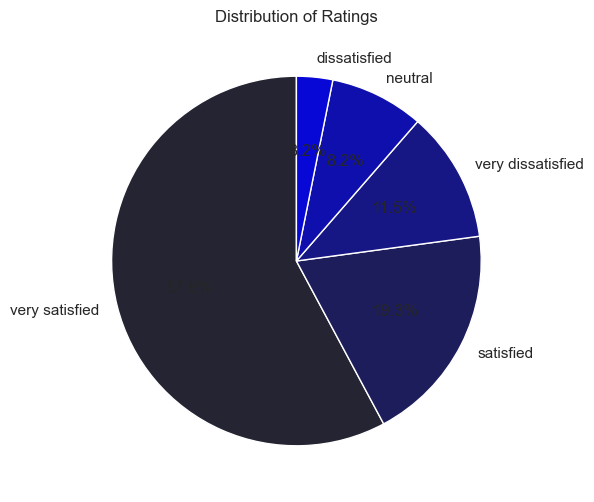

In [156]:
# Assuming you have a DataFrame named olist_order_reviews and a column named 'level_satisfaction'
order = olist_order_reviews['level_satisfaction'].value_counts().index

# Set the 'seaborn' style (optional)
sns.set(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 6))
sns.countplot(x='level_satisfaction', data=olist_order_reviews, order=order, palette='dark:blue')

# Set plot labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Average Rating')

# Swap to a pie chart
plt.clf()  # Clear the previous countplot
plt.figure(figsize=(10, 6))
plt.pie(olist_order_reviews['level_satisfaction'].value_counts(), labels=order, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('dark:blue'))

# Set plot title
plt.title('Distribution of Ratings')

# Show the pie chart
plt.show()


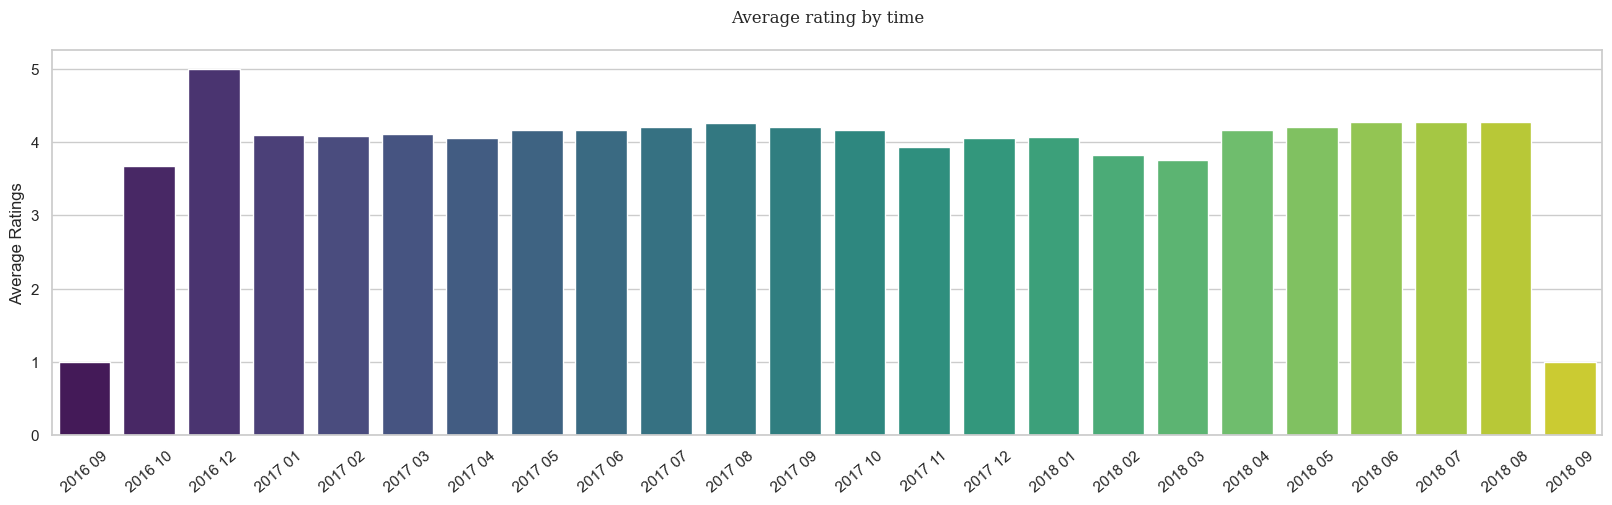

In [157]:
avg_rating_by_year_month = olist.groupby('order_purchase_year_month')['review_score'].mean().reset_index()
avg_rating_by_year_month['review_score'] = avg_rating_by_year_month['review_score'].apply(lambda x: round(x, 2))
#
plt.figure(figsize=(20,5))
sns.barplot(data = avg_rating_by_year_month,x='order_purchase_year_month', y='review_score',label='Average Rating', palette='viridis')
plt.title('Average rating by time', size=14, font='serif', pad=20)
plt.xlabel("")
plt.ylabel("Average Ratings")
plt.xticks(rotation=40)
plt.show()

In [158]:
#create data frame btw product and rating
avg_score_per_category = olist.groupby('product_category_name_english', as_index=False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['product_category_name_english', 'Number of Reviews', 'Average Review Ratings']
avg_score_per_category['Average Review Ratings'] = avg_score_per_category['Average Review Ratings'].apply(lambda x: round(x, 2))
#sorted 20 product
avg_score_per_category = (avg_score_per_category[avg_score_per_category['Number of Reviews'] > 100]
                          .sort_values(by='Number of Reviews', ascending=False)[:20])

In [159]:
# filtering to show only top categories with more than 100 reviews
fig = px.bar(avg_score_per_category, x='product_category_name_english', y='Number of Reviews',
             hover_data=['Average Review Ratings'], color='Average Review Ratings')
fig.show()

In [160]:
olist_products['product_category_name'].nunique()

73

## 6: Payment Type Analysis

In [161]:
def normalize_payment_installments(x):
    if x in range(1, 11):
        return str(x)
    else:
        return 'Others'
        
olist['payment_installments_normalized'] = olist['payment_installments'].apply(normalize_payment_installments)
payment_installments_distribution = olist['payment_installments_normalized'].value_counts().reset_index()

In [162]:
payment_type_counts = (olist.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False)
                          .count()
                          .sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False]))
payment_type_counts

,order_purchase_year_month,payment_type,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,review_response_time,time_to_delivery,delivery_against_estimated,product_volume_cm,order_purchase_year,order_purchase_hour,order_purchase_month,order_purchase_dayofweek,year,month,date,total_revenue,payment_installments_normalized
0,2016 09,Credit Card,2,2,2,2,2,1,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,2,2,2,2,2,2,2,2,2
2,2016 10,Credit Card,238,238,238,238,238,213,210,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,0,167,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,210,210,238,238,238,238,238,238,238,238,238,238
1,2016 10,Boleto,55,55,55,55,55,49,48,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,0,43,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,48,48,55,55,55,55,55,55,55,55,55,55
4,2016 10,Voucher,7,7,7,7,7,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,0,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,6,6,7,7,7,7,7,7,7,7,7,7
3,2016 10,Debit Card,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2018 08,Credit Card,4877,4877,4877,4877,4877,4837,4806,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,1736,1811,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4806,4806,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877
82,2018 08,Boleto,1122,1122,1122,1122,1122,1112,1106,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,414,426,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1106,1106,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122
84,2018 08,Debit Card,273,273,273,273,273,273,267,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,111,119,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,267,267,273,273,273,273,273,273,273,273,273,273
85,2018 08,Voucher,121,121,121,121,121,120,119,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,45,41,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,119,119,121,121,121,121,121,121,121,121,121,121


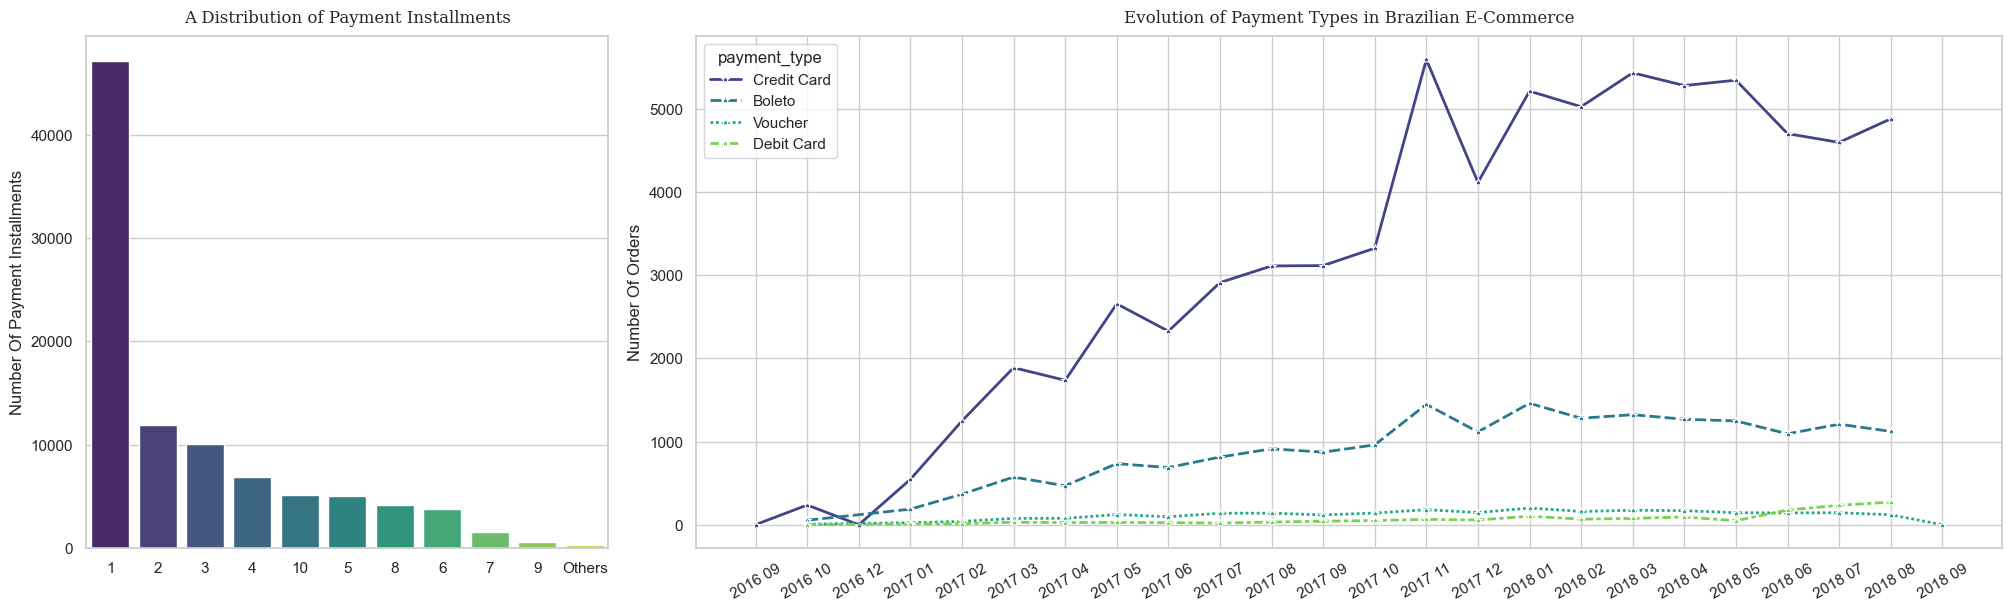

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 5]})

# Plot 1 - Distribution of Payment Installments
payment_installments_distribution = olist['payment_installments_normalized'].value_counts().reset_index()
sns.barplot(data=payment_installments_distribution, x='payment_installments_normalized', y='count', palette='viridis', ax=ax1)
ax1.set_title('A Distribution of Payment Installments', size=14, font='serif', pad=10)
ax1.set_ylabel('Number Of Payment Installments')
ax1.set_xlabel('')

# Plot 2 - Evolution of payment types
payment_type_evolution = (olist.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False)
                          .count()
                          .sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False]))

sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_type_evolution, ax=ax2, hue='payment_type',
             style='payment_type', palette='viridis', marker='*', linewidth=2)
ax2.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=14, font='serif', pad=10)
plt.xticks(rotation=30)
ax2.set_xlabel('')
ax2.set_ylabel('Number Of Orders')
plt.show()

## 8: Number of orders per state

In [164]:
olist_sales_by_states = olist.groupby(by=['customer_state'], as_index=False).agg({
    'order_id': 'count', # number of orders 
    'price': 'sum', # total amount
    'freight_value': ['sum', 'mean'], # total /mean freight amount
    'time_to_delivery': 'mean',
    'delivery_against_estimated': 'mean'
})
updated_columns = []
for e in olist_sales_by_states.columns: 
    if (e[0] == 'freight_value'):
        updated_columns.append(e[0] + '_' + e[1])
    else:
        updated_columns.append(e[0])
olist_sales_by_states.columns = updated_columns

olist_sales_by_states['price_per_order'] = olist_sales_by_states['price'] / olist_sales_by_states['order_id']
olist_sales_by_states['freight_per_order'] = olist_sales_by_states['freight_value_sum'] / olist_sales_by_states['order_id']

for c in  ['price', 'freight_value_sum', 'price_per_order', 'freight_per_order']:
    olist_sales_by_states[c] = olist_sales_by_states[c].apply(round)

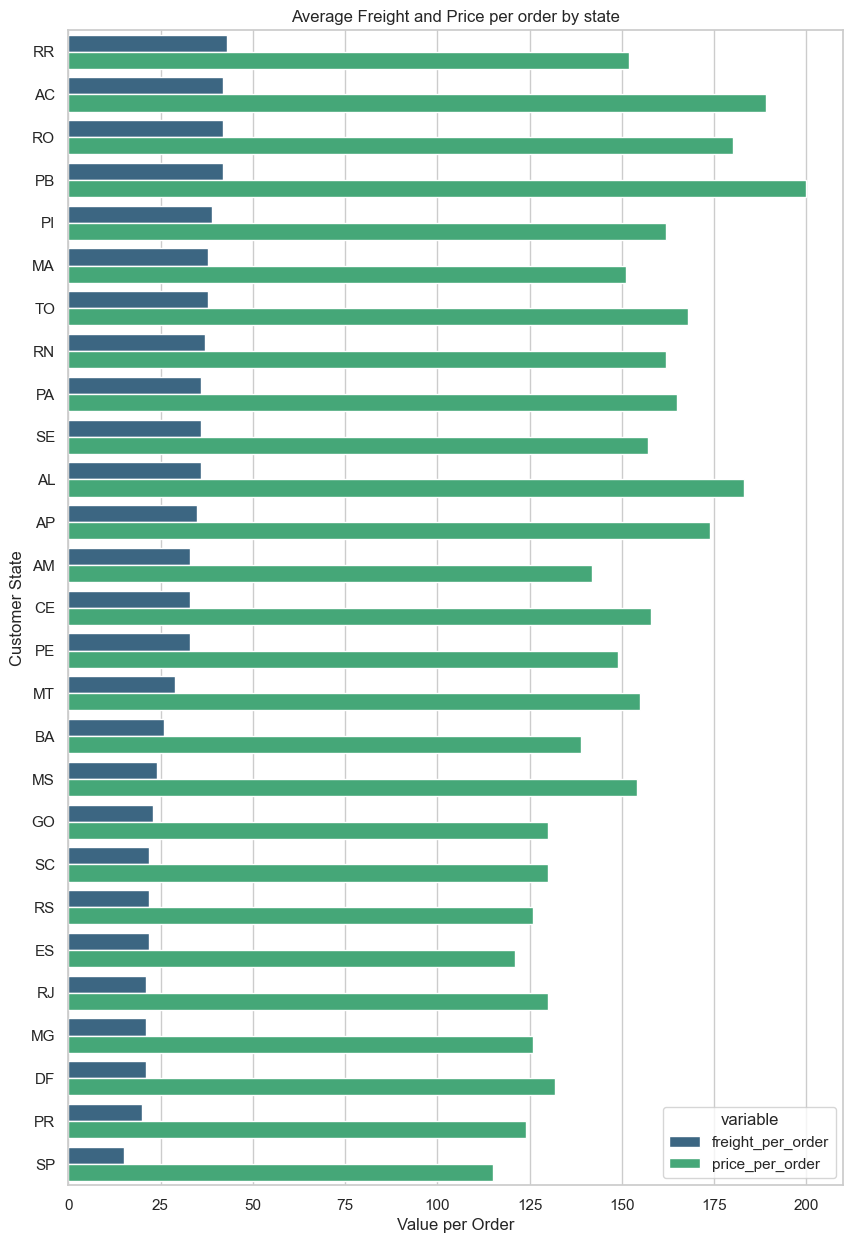

In [166]:
# Sort the DataFrame by 'freight_per_order' and 'price_per_order' separately
sorted_df_freight = olist_sales_by_states.sort_values(by='freight_per_order', ascending=False)
sorted_df_price = olist_sales_by_states.sort_values(by='price_per_order', ascending=False)

# Combine the two DataFrames into a single DataFrame
combined_df = pd.concat([sorted_df_freight, sorted_df_price[['price_per_order']]], axis=1)

# Melt the DataFrame to have a single 'value' column and a 'variable' column indicating the type
melted_df = combined_df.melt(id_vars=['customer_state'], value_vars=['freight_per_order', 'price_per_order'])

# Create the bar plot
plt.figure(figsize=(10, 15))
sns.barplot(data=melted_df, x='value', y='customer_state', hue='variable', palette='viridis')

# Set labels and title
plt.xlabel('Value per Order')
plt.ylabel('Customer State')
plt.title('Average Freight and Price per order by state')

plt.show()


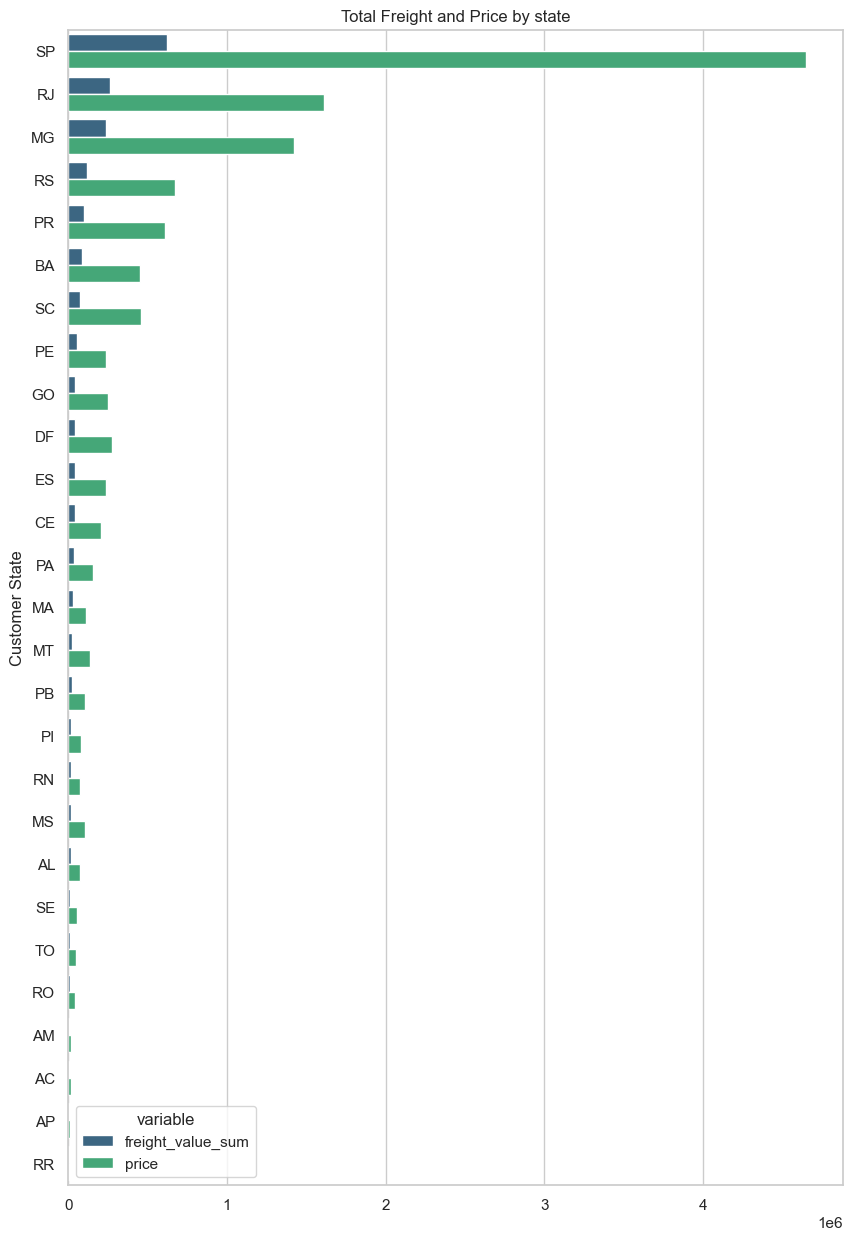

In [167]:
# Sort the DataFrame by 'freight' and 'price' separately
freight_value = olist_sales_by_states.sort_values(by='freight_value_sum', ascending=False)
price = olist_sales_by_states.sort_values(by='price', ascending=False)

combined_freight_price = pd.concat([freight_value, price[['price']]], axis=1)

melted_freight_price = combined_freight_price.melt(id_vars=['customer_state'], value_vars=['freight_value_sum', 'price'])

# Create the bar plot
plt.figure(figsize=(10, 15))
sns.barplot(data=melted_freight_price, x='value', y='customer_state', hue='variable', palette='viridis')

plt.xlabel('')
plt.ylabel('Customer State')
plt.title('Total Freight and Price by state')

plt.show()


### Delivery Time by State

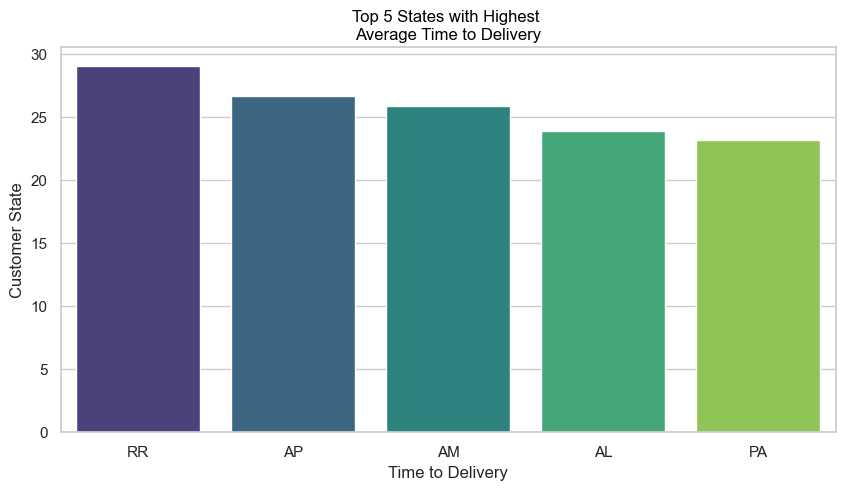

In [198]:
# Plot Pack 02 - Time to delivery on states
plt.figure(figsize=(10,5))
sns.barplot(data=olist_sales_by_states.sort_values(by='time_to_delivery', ascending=False).head(), y='time_to_delivery', x='customer_state',palette='viridis') #chart
plt.title('Top 5 States with Highest \nAverage Time to Delivery', size=12, color='black') #setting playout title
plt.xlabel('Time to Delivery')  # adding x-axis label
plt.ylabel('Customer State')  # adding y-axis label
plt.show()

Text(0, 0.5, 'Customer State')

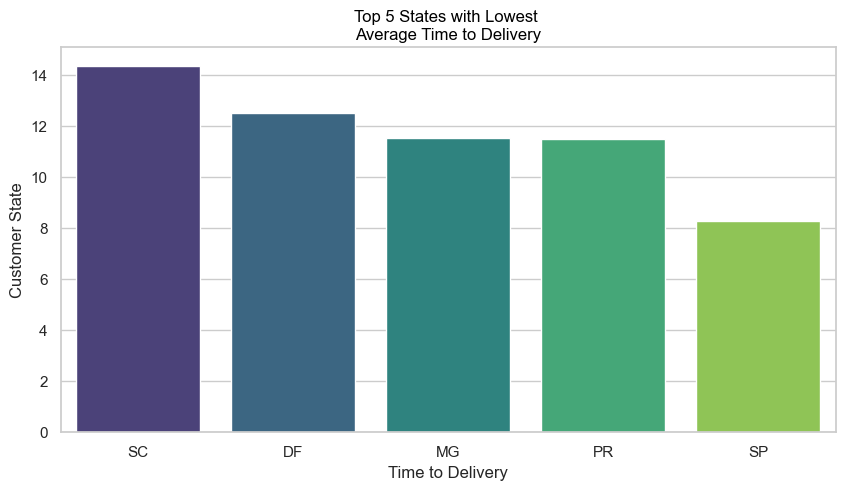

In [199]:
#Time to delivery on states
plt.figure(figsize=(10,5))
ax = sns.barplot(y='time_to_delivery', x='customer_state', data=olist_sales_by_states.sort_values(by='time_to_delivery', ascending=False).tail(), palette='viridis')
plt.title('Top 5 States with Lowest \nAverage Time to Delivery', size=12, color='black')
plt.xlabel('Time to Delivery')  # adding x-axis label
plt.ylabel('Customer State')  # adding y-axis labelplt.show()

## 9: Cusomers by state


In [170]:
olist_customers_by_states = olist.groupby(by=['customer_state'], as_index=False).agg({
    'order_id': 'count'})

Text(0.5, 0, '')

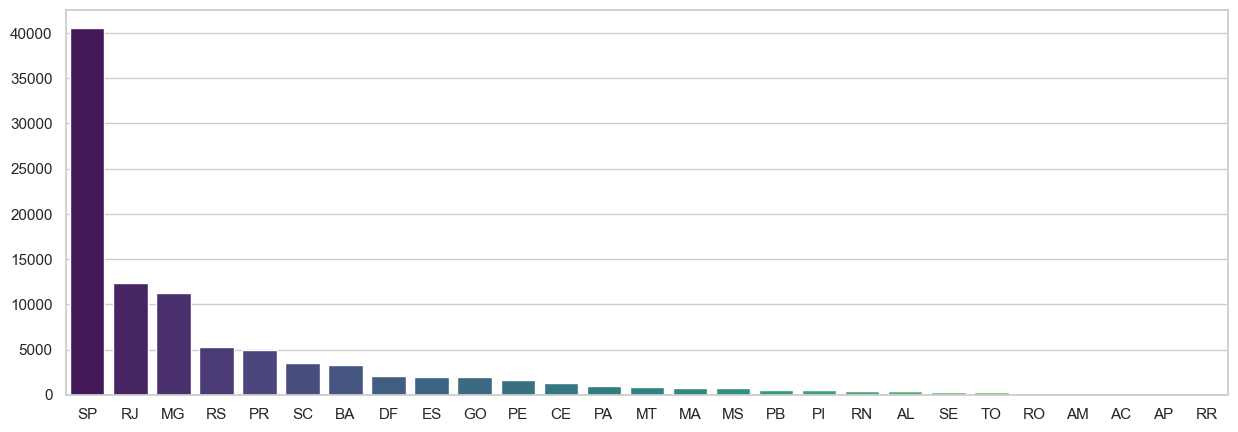

In [171]:
plt.figure(figsize=(15,5))
sns.barplot(y='order_id', x='customer_state', data=olist_customers_by_states.sort_values(by='order_id', ascending=False), palette='viridis')
plt.ylabel('')
plt.xlabel('')

# RFM Analysis

## Customer distribution by purchase time

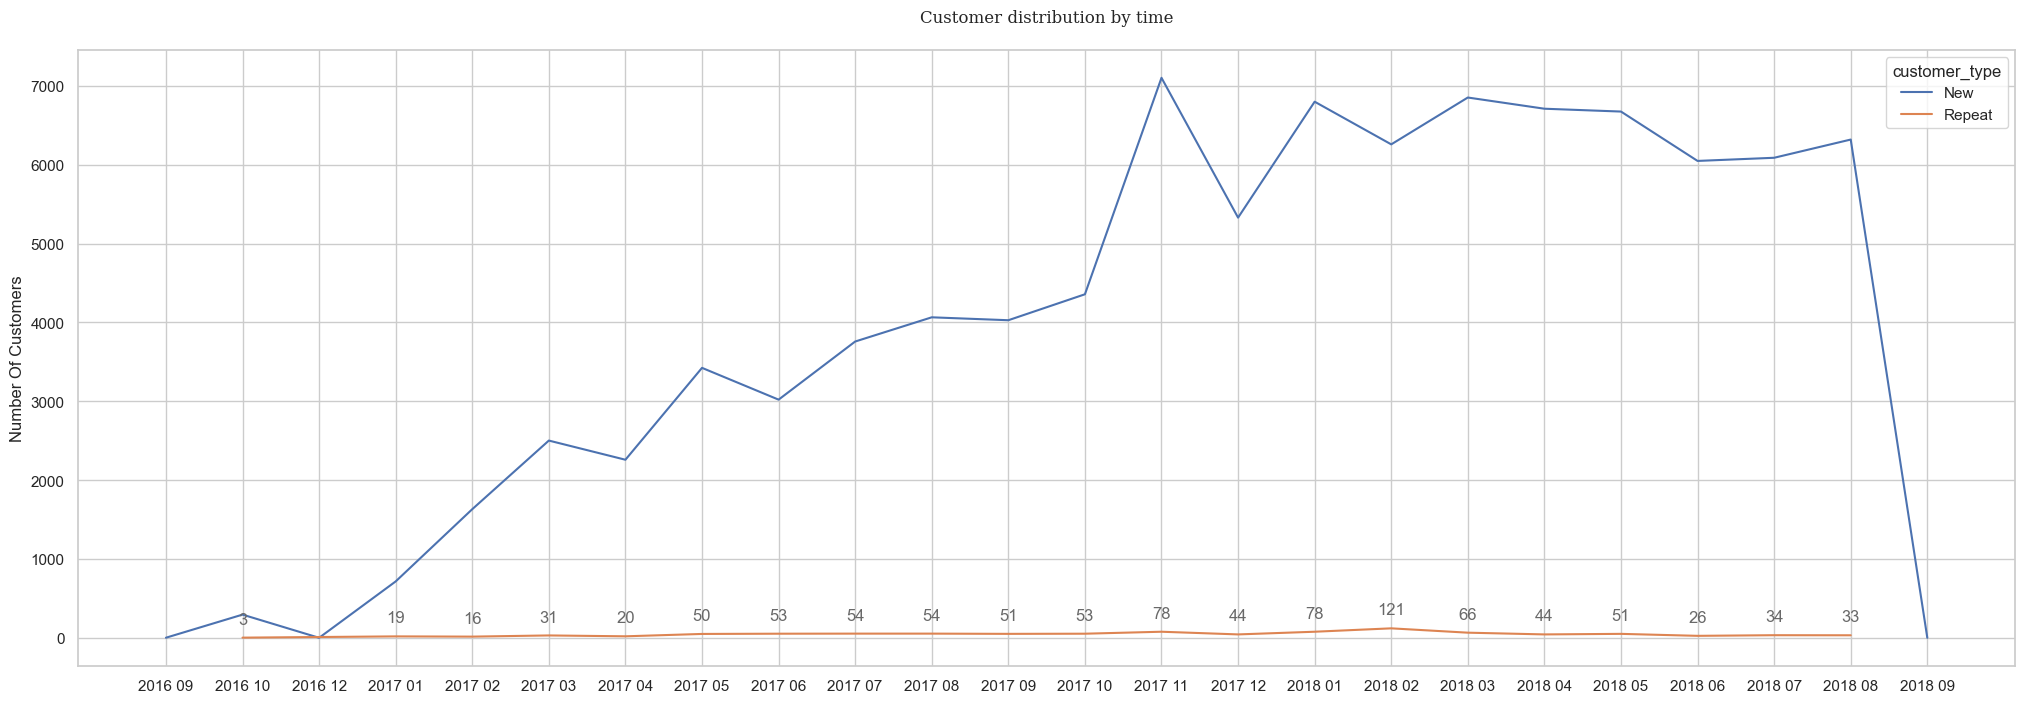

In [172]:
olist['order_purchase_date'] = olist.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
customer_by_time = olist.groupby(['customer_unique_id', 'order_purchase_year_month']).agg({'order_purchase_date': ['nunique', 'first']})
customer_by_time.columns = ['num_of_orders', 'order_first_purchase_date']
customer_by_time['customer_type'] = customer_by_time['num_of_orders'].apply(lambda x: 'Repeat' if x > 1 else 'New')

customer_by_time = customer_by_time.reset_index().groupby(['order_purchase_year_month', 'customer_type'])['customer_unique_id'].count().reset_index()
customer_by_time['order_purchase_year_month'] = customer_by_time.order_purchase_year_month.astype(str)

# Plot
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=customer_by_time, x='order_purchase_year_month', y='customer_unique_id', hue='customer_type')
for x, y in customer_by_time.loc[customer_by_time.customer_type == 'Repeat', ['order_purchase_year_month', 'customer_unique_id']].values:
    ax.annotate(str(y), xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')

ax.set_title('Customer distribution by time', size=14, font='serif', pad=20)
ax.set_xlabel('')
ax.set_ylabel('Number Of Customers')
# 'Although there has been a positive trend in number of New Customers \ngetting registered with Olist in 2017, and more than 6000 purchased each month in 2018, \nthe rate of returning customers is extremely low'
plt.show()

## RFM analysis

In [173]:
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from operator import attrgetter
from datetime import timedelta, datetime

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [174]:
snapshot_date = olist.order_purchase_date.max() + timedelta(days=1)
rfm = (
    olist
    .groupby('customer_unique_id').agg({
        'order_purchase_date': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})
    .rename(columns={
        'order_purchase_date': 'Recency',
        'order_id': 'Frequency',
        'payment_value': 'Monetary'})
)
rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [175]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

f_labels = range(1, 5)
f_groups = pd.cut(rfm['Frequency'], bins=[0, 1, 2, 3, max(rfm['Frequency'])], labels=f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

rfm = rfm.assign(
    R=r_groups.values, 
    F=f_groups.values,
    M=m_groups.values
)
rfm.head()

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1
0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4


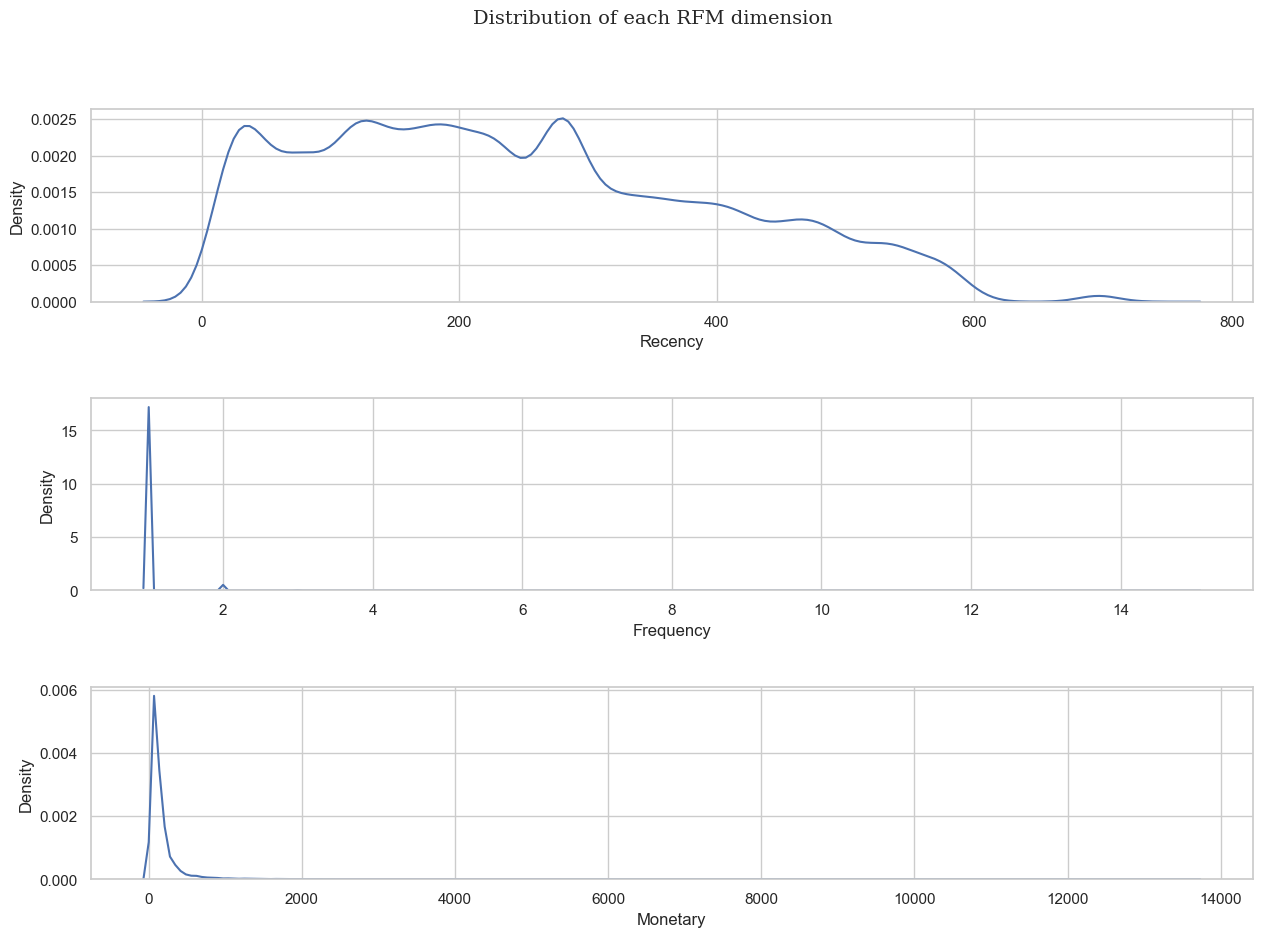

In [176]:
plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
sns.kdeplot(rfm['Recency'])

plt.subplot(3, 1, 2)
sns.kdeplot(rfm['Frequency'])

plt.subplot(3, 1, 3)
sns.kdeplot(rfm['Monetary'])

plt.subplots_adjust(hspace=0.5)

plt.suptitle('Distribution of each RFM dimension', size=14, font='serif')
plt.show()

In [177]:
rfm['RFM_segment'] = rfm[['R', 'F', 'M']].astype(str).apply(''.join, axis=1).astype(int)
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis=1)

def rfm_segment_label(df): # Refer to Wondaris tables
    '''Generate segment label'''
    level = ''
    if df['RFM_score'] >= 10: # at least one dimension = 4 (top)
        level = 'VVIP' 
    elif (df['RFM_score'] >= 8) and (df['M'] == 4):
        level = 'Big Spenders'
    elif df['RFM_score'] >= 6:
        if df['F'] >= 2:
            level = 'Loyal Customers'
        else:
            level = 'Potential Loyalists'
    elif (df['RFM_score'] >= 5) and (df['R'] >= 2) or (df['F'] >= 2):
            level = 'Lagging Customers'
    elif (df['RFM_score'] >= 4) and (df['R'] == 1):
        level = 'Hibernating - Almost Lost'
    else: # RFM_score <= 3 (1, 1, 1)
        level = 'Churned Customers'
        
    return level

rfm['Customer Segment'] = rfm.apply(rfm_segment_label, axis=1)

# Calculate average values for each Customer Segment, and return a size of each segment 
rfm_segment = rfm.groupby('Customer Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
}).round(1)
rfm_segment.columns = ['mean_Recency', 'mean_Frequency', 'mean_Monetary', 'segment_size']

segment_to_action = {
    'VVIP': 'No Price Incentives / Offer Limited edition and Premium loyalty programs',
    'Big Spenders': 'Upsell most expensive items',
    'Loyal Customers': 'Loyalty programs / Cross-sell',
    'Potential Loyalists': 'Cross-sell recommendations and Discount coupons',
    'Lagging Customers': 'Price incentives / Limited coupons / Free delivery / Gift with Purchase',
    'Hibernating - Almost Lost': 'Aggressive price incentives',
    'Churned Customers': 'Don\'t spend too much trying to re-acquire / What can we do better Survey'
}

rfm_segment['Marketing Action'] = rfm_segment.index.map(segment_to_action)
rfm_segment = rfm_segment.reset_index()
rfm_segment

,Customer Segment,mean_Recency,mean_Frequency,mean_Monetary,segment_size,Marketing Action
0,Big Spenders,124.9,1.1,388.6,11755,Upsell most expensive items
1,Churned Customers,373.2,1.0,41.3,11696,Don't spend too much trying to re-acquire / Wh...
2,Hibernating - Almost Lost,455.2,1.0,108.7,11335,Aggressive price incentives
3,Lagging Customers,229.8,1.0,61.7,11858,Price incentives / Limited coupons / Free deli...
4,Loyal Customers,270.2,2.0,199.2,1264,Loyalty programs / Cross-sell
5,Potential Loyalists,190.8,1.0,172.0,44909,Cross-sell recommendations and Discount coupons
6,VVIP,75.4,2.4,437.4,579,No Price Incentives / Offer Limited edition an...


In [178]:
rfm_pivot = (rfm[['R', 'F', 'M']]
             .astype(int)
             .groupby(['R', 'F'])['M'].count()
             .reset_index()
             .pivot(index='R', columns='F', values='M')
)

heatmap_data = go.Heatmap(
    z=rfm_pivot.values,
    y=rfm_pivot.columns,
    x=rfm_pivot.index,
    showscale=True, 
    colorbar=dict(title='Number Of Customers'),
    hovertemplate='Recency: %{x}<br>Frequency: %{y}<br>Number Of Customers: %{z}<extra></extra>'
)

heatmap_layout = go.Layout(
    width=600, height=400,
    title=dict(text='Fig 5: RFM segmentation', font=dict(size=15, family='serif')),
    xaxis={'title':'Recency', 'categoryarray': [1, 2, 3, 4]},
    yaxis={'title': 'Frequency', 'categoryarray': [1, 2, 3, 4]},
    hovermode='closest'
)

fig = go.Figure(data=heatmap_data, layout=heatmap_layout)
fig.show()

In [179]:
rfm_segment['Segment Tiers'] = rfm_segment['Customer Segment'].apply(lambda x: 'Top Tier Segments' if x in ['VVIP', 'Loyal Customers', 'Big Spenders'] 
                                                                     else 'Low Tier Segments')

fig = px.treemap(rfm_segment.rename(columns={'segment_size': 'Segment Size'}), 
                 path=[px.Constant("All Segments"), 'Segment Tiers', 'Customer Segment'], 
                 values='Segment Size', 
                 color='Segment Size', color_continuous_scale='RdBu'
                )

fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25),
    title=dict(text='Customer Segmentation', font=dict(size=18, family='serif')),
    width=800, height=500,
)
fig.show()

# K-Means clustering

## Apply K-Means Clustering to Model

In [181]:
# Filter R, F, M dimension only
rfm_df = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale data
rfm_df_log = rfm_df.apply(lambda x: np.log1p(x))
scaler = StandardScaler().fit(rfm_df_log)
# Scale data
scaler = StandardScaler().fit(rfm_df_log)
rfm_scaled = scaler.transform(rfm_df_log)
rfm_scaled = pd.DataFrame(data=rfm_scaled, index=rfm_df.index, columns=rfm_df.columns)
kmeans = KMeans(n_clusters=5, random_state=42).fit(rfm_scaled)
cluster_labels = kmeans.labels_

# Results
rfm_df_with_cluster = rfm_df.assign(Cluster=cluster_labels)
rfm_df_with_cluster_grouped = rfm_df_with_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
rfm_df_with_cluster_grouped


Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         244.1       1.0    505.0  12445
1         225.8       2.1    305.7   2807
2         282.0       1.0     48.5  26735
3         305.8       1.0    136.8  34824
4          48.9       1.0    122.9  16585

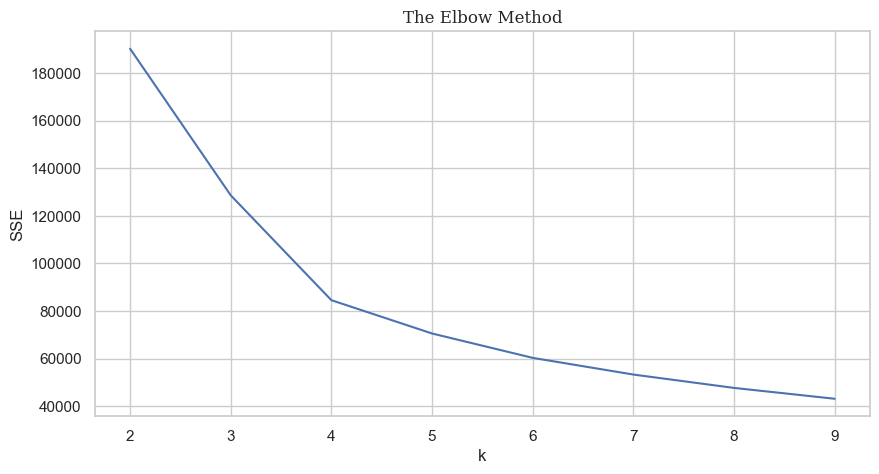

In [182]:
sse = {}
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(10, 5))

plt.title('The Elbow Method', size=14, font='serif')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(sse.keys(), sse.values())
plt.show()

## K-Means Model

In [184]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42).fit(rfm_scaled)
cluster_labels = kmeans.labels_

rfm_df_with_cluster = rfm_df.assign(Cluster=cluster_labels)
rfm_df_with_cluster_grouped = rfm_df_with_cluster.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
rfm_df_with_cluster

,Recency,Frequency,Monetary,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,2
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,0
0000f46a3911fa3c0805444483337064,542,1,86.22,4
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,0
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,4
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,2067.42,5
fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58,4
ffff371b4d645b6ecea244b27531430a,573,1,112.46,4


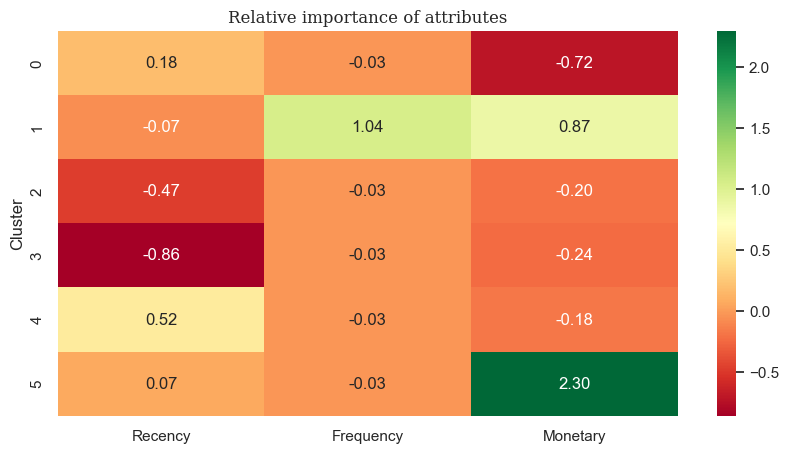

In [185]:
cluster_avg = rfm_df_with_cluster.groupby(['Cluster']).mean() 
population_avg = rfm_df.mean()
relative_imp = cluster_avg / population_avg - 1

plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes', size=14, font='serif')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()